Simulation Results:
   True_Count       MAE  Coverage_95_Pct
0          15  1.027353             98.2
1          20  0.998739             97.3
2          25  0.973467             98.1
3          30  0.915410             98.5
4          35  1.002378             96.9
5          40  1.035220             97.2
6          45  1.001510             97.4
7          50  1.027939             97.2
8          55  1.044938             96.7
9          60  0.967402             97.6


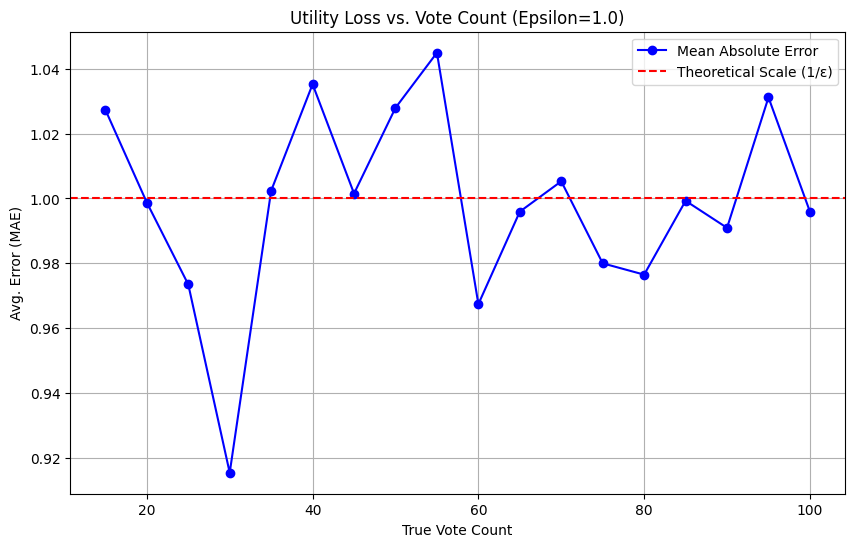

In [2]:
# ==========================================
# PART 1: The DP Mechanism (Adapted for Colab)
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hardcoded config values for simulation
THRESHOLD = 15
EPSILON_PER_QUERY = 1.0
SENSITIVITY = 1

class DPMechanism:
    """
    Implements differential privacy mechanisms for vote counts.
    (Adapted to run standalone in Colab)
    """

    def __init__(self,
                 threshold: int = THRESHOLD,
                 epsilon: float = EPSILON_PER_QUERY,
                 sensitivity: int = SENSITIVITY):
        self.threshold = threshold
        self.epsilon = epsilon
        self.sensitivity = sensitivity

    def check_threshold(self, true_count: int) -> bool:
        return true_count >= self.threshold

    def add_laplace_noise(self, true_count: int) -> float:
        scale = self.sensitivity / self.epsilon
        noise = np.random.laplace(loc=0, scale=scale)
        return true_count + noise

    def release_count(self, true_count: int):
        # Determine if we meet threshold
        if not self.check_threshold(true_count):
            return None, 0.0, False

        # Add noise
        noisy_count = self.add_laplace_noise(true_count)
        return noisy_count, self.epsilon, True

    def calculate_confidence_interval(self, noisy_count: float, confidence: float = 0.95):
        scale = self.sensitivity / self.epsilon
        margin = scale * np.log(2 / (1 - confidence))
        return max(0, noisy_count - margin), noisy_count + margin

# ==========================================
# PART 2: The Evaluation Script
# ==========================================

def run_utility_test():
    dp = DPMechanism(epsilon=1.0)
    results = []

    # Simulate different class sizes (True Votes: 15 to 100)
    true_counts = range(15, 105, 5)

    for count in true_counts:
        errors = []
        covered = 0
        trials = 1000  # Run 1000 simulations per count

        for _ in range(trials):
            noisy, _, _ = dp.release_count(count)

            # 1. Measure Error (Distance from truth)
            if noisy is not None:
                error = abs(noisy - count)
                errors.append(error)

                # 2. Check if true count is inside the Confidence Interval
                lower, upper = dp.calculate_confidence_interval(noisy)
                if lower <= count <= upper:
                    covered += 1

        avg_mae = np.mean(errors) if errors else 0
        coverage_pct = (covered / trials) * 100

        results.append({
            "True_Count": count,
            "MAE": avg_mae,
            "Coverage_95_Pct": coverage_pct
        })

    # Create Dataframe
    df = pd.DataFrame(results)

    # Print Table
    print("Simulation Results:")
    print(df.head(10))  # Show first 10 rows

    # Plot Graph
    plt.figure(figsize=(10, 6))
    plt.plot(df["True_Count"], df["MAE"], marker='o', linestyle='-', color='b', label='Mean Absolute Error')
    plt.axhline(y=1.0, color='r', linestyle='--', label='Theoretical Scale (1/ε)')
    plt.title(f"Utility Loss vs. Vote Count (Epsilon={EPSILON_PER_QUERY})")
    plt.xlabel("True Vote Count")
    plt.ylabel("Avg. Error (MAE)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    run_utility_test()